In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Task 1: Data Extraction and Preprocessing

**import necessary libraries**

In [1]:
import os
import csv
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

**1 - Data Loading and Preprocessin**

In [2]:
# Paths to the datasets and mappings
path_for_trainData = '/kaggle/input/dataset/characters.csv'
path_for_testData = '/kaggle/input/dataset/characters-test.csv'
path_for_mappingFile = '/kaggle/input/dataset/mapping.txt'

# chech the exist exist
for path in [path_for_trainData, path_for_testData, path_for_mappingFile]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file not found : {os.path.abspath(path)}")


def readCSVFile(csv_path):

    df = pd.read_csv(csv_path)
    
    print("First 5 rows of the file:")
    print(df.head())  # Print the first 5 rows of the DataFrame
    
    # Print number of rows and columns
    print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
    
    # Process data into labels and pixels
    labels = df.iloc[:, 0].values
    pixels = df.iloc[:, 1:].values / 255.0  # Normalize pixel values to range [0, 1]
    images = pixels.reshape(-1, 28, 28).astype(np.float32)  # Reshape into 28x28 images
    return images, labels, df


# Load training data
print("Loading training data...")
X_train, y_train, train_df = readCSVFile(path_for_trainData)
print(f"Number of training samples: {train_df.shape[0]} rows and {train_df.shape[1]} columns.")

# Load test data
print("Loading test data...")
X_test, y_test, test_df = readCSVFile(path_for_testData)
print(f"Number of test samples: {test_df.shape[0]} rows and {test_df.shape[1]} columns.")



Loading training data...
First 5 rows of the file:
   45  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.524  0.525  0.526  \
0  36  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  43  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  15  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3   4  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  42  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.527  0.528  0.529  0.530  0.531  0.532  0.533  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]
Dataset contains 112799 rows and 785 columns.
Number of training samples: 112799 rows and 785 columns.
Loading test data...
First 5 rows o

**2 - Load mappings from mappings**

In [3]:
# Load mappings from mappings.txt
def load_mappings(mapping_path):
    mapping = {}
    with open(mapping_path, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file, start=1):
            parts = line.strip().split()
            
            if len(parts) < 2:
                print(f"Skipping line {line_number}: Invalid format.")
                continue
            try:
                label = int(parts[0])
                ascii_code = int(parts[1])
                mapping[label] = chr(ascii_code)
            except ValueError:
                print(f"Skipping line {line_number}: Invalid label or ASCII code.")
            except Exception as error:
                print(f"Skipping line {line_number} due to error: {error}")
    
    print(f"Loaded {len(mapping)} mappings.")
    return mapping


label_to_char = load_mappings(path_for_mappingFile)

# Print firest 15 label from mapping file 
print("\n Label Mapping (First 15):")
for label in sorted(label_to_char.keys())[:15]:
    print(f"Label {label}: '{label_to_char[label]}'")

Loaded 47 mappings.

 Label Mapping (First 15):
Label 0: '0'
Label 1: '1'
Label 2: '2'
Label 3: '3'
Label 4: '4'
Label 5: '5'
Label 6: '6'
Label 7: '7'
Label 8: '8'
Label 9: '9'
Label 10: 'A'
Label 11: 'B'
Label 12: 'C'
Label 13: 'D'
Label 14: 'E'


**3 - Dataset and DataLoader**

In [4]:
class datasetForCharacters(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(int)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = Image.fromarray((image * 255).astype(np.uint8))
            image = self.transform(image)
        else:
            # If no transform, convert to tensor
            image = torch.tensor(image).unsqueeze(0)  
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


batch_size = 64

# Create Datasets
trainset = datasetForCharacters(X_train, y_train, transform=transform)
testset = datasetForCharacters(X_test, y_test, transform=transform)

# Create DataLoaders
trainLoader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testLoader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


**4 - CNN Model Definitions and Define Pre-trained Model (ResNet18)**

In [5]:
class CNNClassifierModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifierModel, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Feature extraction
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define Pre-trained Model (ResNet18)
class PretrainResnet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainResnet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the final fully connected layer to match the number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Determine number of classes
num_classes = len(np.unique(y_train))
print(f"\nNumber of character classes: {num_classes}")

# Initialize models
cnn_model = CNNClassifierModel(num_classes=num_classes)
resnet_model = PretrainResnet18(num_classes=num_classes)

# Print model architectures
print("\nCustom CNN Model:")
print(cnn_model)
print("\nPre-trained ResNet18 Model:")
print(resnet_model)


Number of character classes: 47


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 



Custom CNN Model:
CNNClassifierModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

Pre-trained ResNet18 Model:
PretrainResnet18(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlo

**5 - Function Training Modles**

In [6]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Move models to device
cnn_model = cnn_model.to(device)
resnet_model = resnet_model.to(device)

# Define loss and optimizers
criterion = nn.CrossEntropyLoss()

# For CNN
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

# For ResNet
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, trainLoader, criterion, device, numberOfEpoch=1):
    model.train()
    loss_history = []
    accuracy_history = []
    for epoch in range(numberOfEpoch):
        running_loss = 0.0
        correct = 0
        total = 0

        for images_batch, labels_batch in tqdm(trainLoader, desc=f"Epoch {epoch+1}/{numberOfEpoch}"):
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images_batch.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)

        epoch_loss = running_loss / len(trainLoader.dataset)
        epoch_accuracy = correct / total
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        print(f"Epoch [{epoch+1}/{numberOfEpoch}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return loss_history, accuracy_history


Using device: cuda


**6 - Function Evaluation Models Performance**

In [7]:
# Evaluation function
def evaluateModelsPerformance(model, testLoader, device, label_mapping, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images_batch, labels_batch in testLoader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            outputs = model(images_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")
    
    # Calculate precision, recall, f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=[label_mapping.get(i, 'Unknown') for i in range(num_classes)])
    print("\nClassification Report:")
    print(report)
    
    return acc, all_preds, all_labels, precision, recall, f1

**7 - Training Models**

In [8]:
# Define number of epochs
numberOfEpoch = 10  

# Train Custom CNN
print("\nTraining CNN Model...")
lossCnn, accuracyCnn = train_model(cnn_model, optimizer_cnn, trainLoader, criterion, device, numberOfEpoch=numberOfEpoch)

# Save the trained CNN model
torch.save(cnn_model.state_dict(), 'cnn_model.pth')
print("CNN model saved as 'cnn_model.pth'.")

# Train Pre-trained ResNet18
print("\nTraining Pre-trained ResNet18 Model...")
lossResnet, accuracyResnet = train_model(resnet_model, optimizer_resnet, trainLoader, criterion, device, numberOfEpoch=numberOfEpoch)

# Save the trained ResNet model
torch.save(resnet_model.state_dict(), 'resnet_model.pth')
print("Pre-trained ResNet18 model saved as 'resnet_model.pth'.")



Training CNN Model...


Epoch 1/10: 100%|██████████| 1763/1763 [00:20<00:00, 84.96it/s] 


Epoch [1/10] - Loss: 1.2420, Accuracy: 0.6198


Epoch 2/10: 100%|██████████| 1763/1763 [00:18<00:00, 94.43it/s] 


Epoch [2/10] - Loss: 0.7882, Accuracy: 0.7434


Epoch 3/10: 100%|██████████| 1763/1763 [00:18<00:00, 95.87it/s] 


Epoch [3/10] - Loss: 0.6714, Accuracy: 0.7781


Epoch 4/10: 100%|██████████| 1763/1763 [00:18<00:00, 94.64it/s] 


Epoch [4/10] - Loss: 0.6104, Accuracy: 0.7960


Epoch 5/10: 100%|██████████| 1763/1763 [00:18<00:00, 94.79it/s] 


Epoch [5/10] - Loss: 0.5717, Accuracy: 0.8083


Epoch 6/10: 100%|██████████| 1763/1763 [00:18<00:00, 93.60it/s] 


Epoch [6/10] - Loss: 0.5377, Accuracy: 0.8178


Epoch 7/10: 100%|██████████| 1763/1763 [00:18<00:00, 93.48it/s] 


Epoch [7/10] - Loss: 0.5150, Accuracy: 0.8238


Epoch 8/10: 100%|██████████| 1763/1763 [00:18<00:00, 96.38it/s] 


Epoch [8/10] - Loss: 0.4974, Accuracy: 0.8298


Epoch 9/10: 100%|██████████| 1763/1763 [00:18<00:00, 93.71it/s] 


Epoch [9/10] - Loss: 0.4840, Accuracy: 0.8321


Epoch 10/10: 100%|██████████| 1763/1763 [00:18<00:00, 93.94it/s] 


Epoch [10/10] - Loss: 0.4723, Accuracy: 0.8368
CNN model saved as 'cnn_model.pth'.

Training Pre-trained ResNet18 Model...


Epoch 1/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.21it/s]


Epoch [1/10] - Loss: 0.6706, Accuracy: 0.7838


Epoch 2/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.19it/s]


Epoch [2/10] - Loss: 0.4184, Accuracy: 0.8544


Epoch 3/10: 100%|██████████| 1763/1763 [00:40<00:00, 43.17it/s]


Epoch [3/10] - Loss: 0.3666, Accuracy: 0.8708


Epoch 4/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.56it/s]


Epoch [4/10] - Loss: 0.3347, Accuracy: 0.8791


Epoch 5/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.54it/s]


Epoch [5/10] - Loss: 0.3097, Accuracy: 0.8864


Epoch 6/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.68it/s]


Epoch [6/10] - Loss: 0.2912, Accuracy: 0.8921


Epoch 7/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.74it/s]


Epoch [7/10] - Loss: 0.2691, Accuracy: 0.8980


Epoch 8/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.43it/s]


Epoch [8/10] - Loss: 0.2539, Accuracy: 0.9027


Epoch 9/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.84it/s]


Epoch [9/10] - Loss: 0.2435, Accuracy: 0.9061


Epoch 10/10: 100%|██████████| 1763/1763 [00:41<00:00, 42.86it/s]

Epoch [10/10] - Loss: 0.2283, Accuracy: 0.9102
Pre-trained ResNet18 model saved as 'resnet_model.pth'.


**8 - Evaluating Models**

In [9]:
print("\nEvaluating Custom CNN Model on Test Set:")
cnn_model.load_state_dict(torch.load('cnn_model.pth'))
cnn_model.to(device)
cnn_accurecy, cnn_preds, cnn_labels, cnn_precision, cnn_recall, cnn_f1_score = evaluateModelsPerformance(cnn_model, testLoader, device, label_to_char, num_classes)

print("\nEvaluating Pre-trained ResNet18 Model on Test Set:")
resnet_model.load_state_dict(torch.load('resnet_model.pth'))
resnet_model.to(device)
resnet_acc, resnet_preds, resnet_labels, resnet_precision, resnet_recall, resnet_f1 = evaluateModelsPerformance(resnet_model, testLoader, device, label_to_char, num_classes)



Evaluating Custom CNN Model on Test Set:


<ipython-input-9-3588212fefb1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load('cnn_model.pth'))


Validation Accuracy: 0.8657
Precision: 0.8683, Recall: 0.8657, F1-Score: 0.8621

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.21      0.32       400
           1       0.53      0.61      0.57       400
           2       0.93      0.83      0.88       400
           3       0.99      0.98      0.98       400
           4       0.93      0.88      0.90       400
           5       0.91      0.90      0.90       400
           6       0.92      0.94      0.93       400
           7       0.96      0.98      0.97       400
           8       0.93      0.93      0.93       400
           9       0.66      0.85      0.75       400
           A       0.96      0.97      0.97       400
           B       0.97      0.97      0.97       400
           C       0.96      0.94      0.95       400
           D       0.92      0.92      0.92       400
           E       0.97      0.97      0.97       400
           F       0.62      0.

<ipython-input-9-3588212fefb1>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet_model.pth'))


Validation Accuracy: 0.8886
Precision: 0.8922, Recall: 0.8886, F1-Score: 0.8875

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       400
           1       0.51      0.80      0.62       400
           2       0.93      0.91      0.92       400
           3       0.99      0.98      0.99       400
           4       0.94      0.95      0.95       400
           5       0.97      0.88      0.92       400
           6       0.96      0.92      0.94       400
           7       0.97      0.99      0.98       400
           8       0.97      0.92      0.94       400
           9       0.70      0.81      0.75       400
           A       0.97      0.99      0.98       400
           B       0.97      0.97      0.97       400
           C       0.94      0.97      0.96       400
           D       0.94      0.94      0.94       400
           E       0.98      0.99      0.99       400
           F       0.64      0.

**9 - Comparing Performances**

In [10]:
print("\n####### Model Performance Comparison #######")
print(f"Accurecy For CNN Model: {cnn_accurecy:.4f}")
print(f"Accuracy For Pre-trained ResNet18: {resnet_acc:.4f}")

# Create a summary of performance for both models
performanceOfModels = {
    'Custom CNN': {
        'Accuracy': cnn_accurecy,
        'Precision': cnn_precision,
        'Recall': cnn_recall,
        'F1-Score': cnn_f1_score
    },
    'Pre-trained ResNet18': {
        'Accuracy': resnet_acc,
        'Precision': resnet_precision,
        'Recall': resnet_recall,
        'F1-Score': resnet_f1
    }
}

# Display performance comparison
print("\nPerformance Comparison:")
for modelName, metrics in performanceOfModels.items():
    print(f"\n{modelName}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


####### Model Performance Comparison #######
Accurecy For CNN Model: 0.8657
Accuracy For Pre-trained ResNet18: 0.8886

Performance Comparison:

Custom CNN:
  Accuracy: 0.8657
  Precision: 0.8683
  Recall: 0.8657
  F1-Score: 0.8621

Pre-trained ResNet18:
  Accuracy: 0.8886
  Precision: 0.8922
  Recall: 0.8886
  F1-Score: 0.8875


**10 - Save Evaluation Results with DataFrame**

In [15]:
# Function to generate classification report as DataFrame
def creatReport(true, preds, labels, num_classes):
    target_names = [labels.get(i, 'Unknown') for i in range(num_classes)]
    return pd.DataFrame(classification_report(true, preds, target_names=target_names, output_dict=True)).T

# Generate classification reports
reportForCnn = creatReport(cnn_labels, cnn_preds, label_to_char, num_classes)
reportForResnet = creatReport(resnet_labels, resnet_preds, label_to_char, num_classes)

# Simplify evaluation results dictionary
evaluation_results = {
    "Custom_CNN": {
        "Accuracy": cnn_accurecy,
        "Precision": cnn_precision,
        "Recall": cnn_recall,
        "F1-Score": cnn_f1_score,
        "Report": reportForCnn
    },
    "ResNet18": {
        "Accuracy": resnet_acc,
        "Precision": resnet_precision,
        "Recall": resnet_recall,
        "F1-Score": resnet_f1,
        "Report": reportForResnet
    }
}



**11 - Plotting Loss and Accuracy**

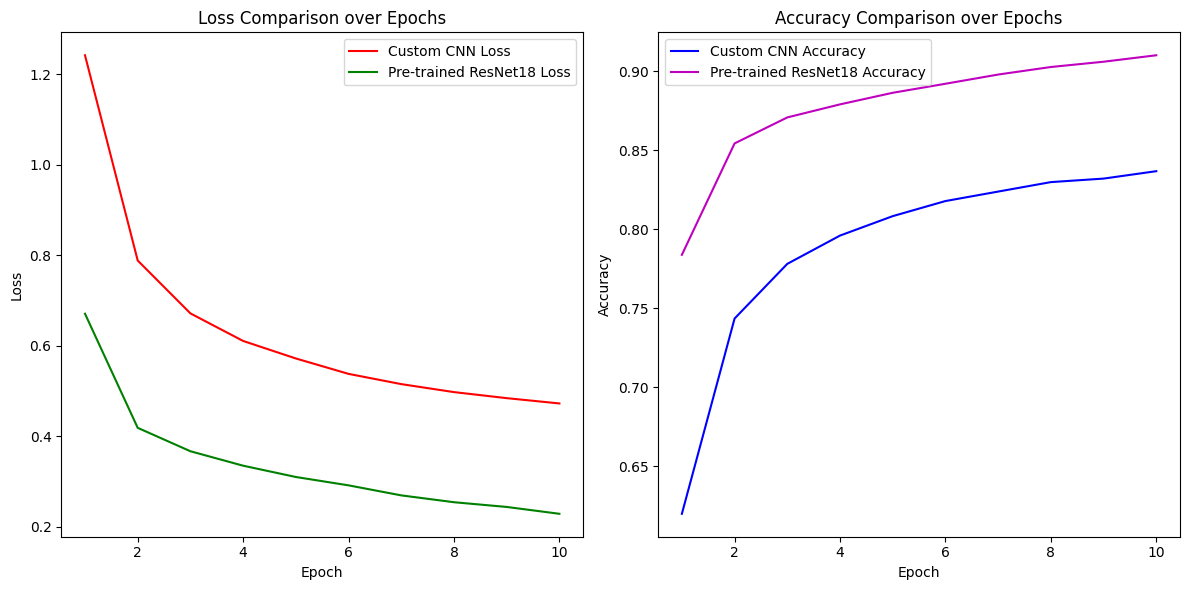

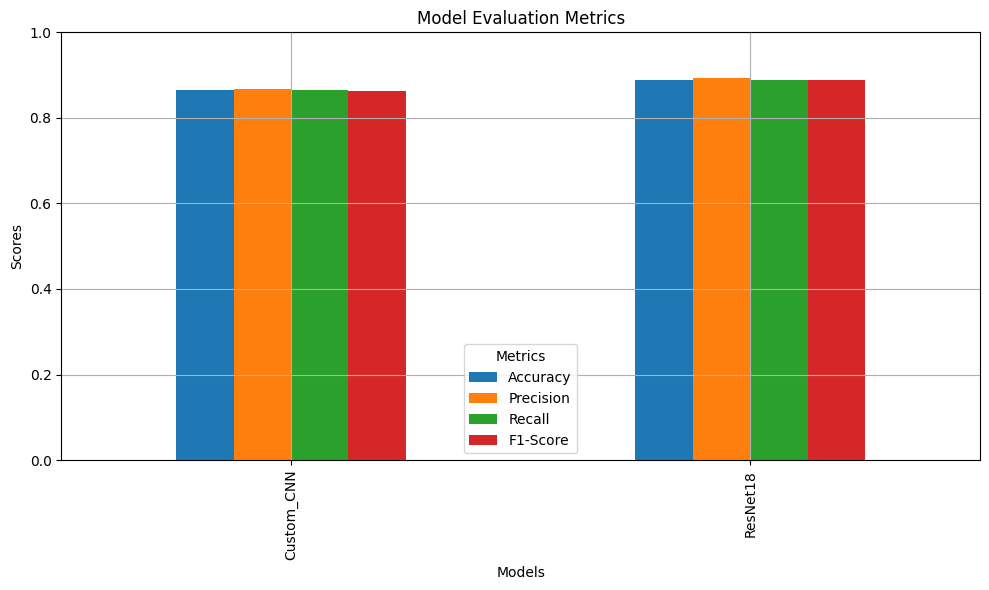

In [14]:
def metrixCompersion(loss1, accuracy1, modelName1, loss2, accuracy2, modelName2):

    epo1 = range(1, len(loss1) + 1)
    epo2 = range(1, len(loss2) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epo1, loss1, 'r-', label=f'{modelName1} Loss')
    plt.plot(epo2, loss2, 'g-', label=f'{modelName2} Loss')
    plt.title('Loss Comparison over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epo1, accuracy1, 'b-', label=f'{modelName1} Accuracy')
    plt.plot(epo2, accuracy2, 'm-', label=f'{modelName2} Accuracy')
    plt.title('Accuracy Comparison over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot metrics for Custom CNN vs Pre-trained ResNet18
metrixCompersion(lossCnn, accuracyCnn, 'Custom CNN', lossResnet, accuracyResnet, 'Pre-trained ResNet18')

# Visualization Compare Metrics Between Two Models
def barChartForTwoModels(evaluation_results):
    metrics_df = pd.DataFrame(evaluation_results).T[["Accuracy", "Precision", "Recall", "F1-Score"]]
    
    # Plot bar charts
    metrics_df.plot(kind="bar", figsize=(10, 6), ylim=(0, 1), grid=True)
    plt.title("Model Evaluation Metrics")
    plt.xlabel("Models")
    plt.ylabel("Scores")
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()

# Call the function
barChartForTwoModels(evaluation_results)


# Task 2: Subjectivity Classification

**import necessary libraries**

In [3]:
# !pip install transformers
# !pip install tqdm
# !pip install seaborn
# !pip install scikit-learn
# !pip install torchmetrics

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, matthews_corrcoef)
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(f"Using device is : {device}")

Using device is : cuda


**1 - Data Loading and Preprocessing**

In [5]:
# file paths
train_data_path = '/kaggle/input/dataset/train_en.tsv'
test_data_path = '/kaggle/input/dataset/test_en_gold.tsv'


def load_training_data(file_path, delimiter='\t'):
    try:
        data = pd.read_csv(file_path, sep=delimiter)
        print(f"Loaded training data with shape: {data.shape}")
        print("Here is a sample of the data:")
        print(data.head())
        return data
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except pd.errors.ParserError:
        print("Error: Failed to parse the file. Please check the delimiter and file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

train_df = load_training_data(train_data_path)
print("------------------------------------------------------------")

def load_testing_data(file_path, delimiter='\t'):
    try:
        data = pd.read_csv(file_path, sep=delimiter)
        print(f"Loaded testing data with shape: {data.shape}")
        print("Here is a sample of the data:")
        print(data.head())
        return data
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except pd.errors.ParserError:
        print("Error: Failed to parse the file. Please check the delimiter and file format.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

test_df = load_testing_data(test_data_path)


# Display label distribution in training data
print("\nLabel Distribution in Training Data:")
print(train_df['label'].value_counts())

# Define label encoding
label_mapping = {'OBJ': 0, 'SUBJ': 1}

# Apply encoding to training and testing data
train_df['label_encoded'] = train_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Verify encoding 
print("\nEncoded Labels in Training Data:")
print(train_df[['label', 'label_encoded']].head())
print("\nEncoded Labels in Testing Data:")
print(test_df[['label', 'label_encoded']].head())

Loaded training data with shape: (830, 4)
Here is a sample of the data:
                            sentence_id  \
0  b9e1635a-72aa-467f-86d6-f56ef09f62c3   
1  f99b5143-70d2-494a-a2f5-c68f10d09d0a   
2  4076639c-aa56-4202-ae0f-9d9217f8da68   
3  b057c366-698e-419d-a284-9b16d835c64e   
4  a5a9645e-7850-41ba-90a2-5def725cd5b8   

                                            sentence label  solved_conflict  
0  Gone are the days when they led the world in r...  SUBJ             True  
1  The trend is expected to reverse as soon as ne...   OBJ            False  
2             But there is the specious point again.   OBJ            False  
3  He added he wouldn’t be surprised to see a new...   OBJ            False  
4  Not less government, you see; the same amount ...  SUBJ            False  
------------------------------------------------------------
Loaded testing data with shape: (243, 3)
Here is a sample of the data:
                            sentence_id  \
0  8745d4da-91c9-4538-acee

**2 - Dataset and DataLoader**

In [6]:
class DatasetSubjectivity(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128, model_type='lstm'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model_type = model_type 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = str(self.data.iloc[idx]['sentence'])
        label = self.data.iloc[idx]['label_encoded']

        if self.model_type == 'bert':
            encoding = self.tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                max_length=self.max_length,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt',
            )
            return {
                'sentence_text': sentence,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            encoding = self.tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt',
            )
            return {
                'sentence_text': sentence,
                'input_ids': encoding['input_ids'].flatten(),
                'labels': torch.tensor(label, dtype=torch.long)
            }

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_data, val_data = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df['label_encoded']
)

print(f"\nNumber of Training samples: {train_data.shape[0]}")
print(f"Number of Validation samples: {val_data.shape[0]}")

# Define maximum sequence length
MAX_LENGTH = 128
# Define batch sizes for different models
batch_size_lstm = 64
batch_size_bert = 32 

model_types = ['lstm', 'bert']
data_splits = {
    'train': train_data,
    'val': val_data,
    'test': test_df
}

# Initialize a dictionary to hold all datasets
datasets = {}

# Loop through each model type and data split to create datasets
for model in model_types:
    datasets[model] = {
        split: DatasetSubjectivity(
            data,
            tokenizer=bert_tokenizer,
            max_length=MAX_LENGTH,
            model_type=model
        )
        for split, data in data_splits.items()
    }

# Accessing the datasets
train_dataset_lstm = datasets['lstm']['train']
val_dataset_lstm = datasets['lstm']['val']
test_dataset_lstm = datasets['lstm']['test']

train_dataset_bert = datasets['bert']['train']
val_dataset_bert = datasets['bert']['val']
test_dataset_bert = datasets['bert']['test']

# Create DataLoaders
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size_lstm, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size_lstm, shuffle=False)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size_bert, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=batch_size_bert, shuffle=False)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size_bert, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Number of Training samples: 747
Number of Validation samples: 83


**3 - LSTM Model Definitions**

In [6]:
class LSTMModelClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, n_layers, bidirectional, dropout, pad_size):
        
        super(LSTMModelClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_size)
        
        self.lstm = nn.LSTM(
            embedding_size, 
            hidden_size, 
            num_layers=n_layers, 
            bidirectional=bidirectional, 
            batch_first=True,
            dropout=dropout if n_layers >1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # [batch_size, seq_len, embedding_size]
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: [batch, seq, hidden*direc]
        
        # Concatenate the final forward and backward hidden state
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.fc(hidden)
        return output

**4 - BERT Model Definitions**

In [7]:
# BERT-Based Model Definition
class BERTModelClassifier(nn.Module):
    def __init__(self, n_classes):

        super(BERTModelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]  
        output = self.dropout(pooled_output)
        return self.out(output)

**5 - Training and Evaluation Functions**

In [8]:
def trainingEpoch(model, data_loader, lossFn, optimizer, device, scheduler=None, model_type='lstm'):
  
    model.train()
    losses = []
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        if model_type == 'bert':
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        else:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids)
        
        _, preds = torch.max(outputs, dim=1)
        loss = lossFn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
    
    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def evaluationMmodel(model, data_loader, lossFn, device, model_type='lstm'):
 
    model.eval()
    losses = []
    correct_predictions = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            if model_type == 'bert':
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
            
            _, preds = torch.max(outputs, dim=1)
            loss = lossFn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    
    return acc, avg_loss, all_preds, all_labels

def getEvaluationMetrics(preds, labels, label_mapping):
  
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    report = classification_report(labels, preds, target_names=['OBJ', 'SUBJ'])
    cm = confusion_matrix(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return accuracy, precision, recall, f1, report, cm, mcc

**6 - Training the LSTM Model**

In [9]:
# Define initial hyperparameters for LSTM
initial_hyperparameters = {
    'learning_rate': 1e-3,
    'hidden_size': 256,
    'n_layers': 2,
    'dropout': 0.5,
    'batch_size': 64
}

# Initialize the LSTM model with initial hyperparameters
lstm_model = LSTMModelClassifier(
    vocab_size=len(bert_tokenizer),
    embedding_size=128,
    hidden_size=initial_hyperparameters['hidden_size'],
    output_size=2,
    n_layers=initial_hyperparameters['n_layers'],
    bidirectional=True,
    dropout=initial_hyperparameters['dropout'],
    pad_size=bert_tokenizer.pad_token_id
)

# Move model to device
lstm_model = lstm_model.to(device)

# Define Early Stopping parameters
patience = 3  
bestValLoss_lstm = float('inf')
epochsNoImprove = 0

# Define class weights to handle class imbalance
classCounts = train_df['label_encoded'].value_counts().sort_index()
classWeights = 1. / torch.tensor(classCounts, dtype=torch.float)
classWeights = classWeights.to(device)

# Define loss function and optimizer
lossFunctLstm = nn.CrossEntropyLoss(weight=classWeights).to(device)
optimizerLstm = optim.Adam(lstm_model.parameters(), lr=initial_hyperparameters['learning_rate'])



# Number of epochs
epochs = 10 

# Train the initial LSTM model 
perfLstm = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 10)
    
    train_acc, train_loss = trainingEpoch(
        model=lstm_model,
        data_loader=train_loader_lstm,
        lossFn=lossFunctLstm,
        optimizer=optimizerLstm,
        device=device,
        scheduler=None,  # No scheduler for LSTM
        model_type='lstm'
    )
    
    print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")
    
    val_acc, val_loss, _, _ = evaluationMmodel(
        model=lstm_model,
        data_loader=val_loader_lstm,
        lossFn=lossFunctLstm,
        device=device,
        model_type='lstm'
    )
    
    print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")
    
    perfLstm['train_acc'].append(train_acc.cpu().numpy())
    perfLstm['train_loss'].append(train_loss)
    perfLstm['val_acc'].append(val_acc.cpu().numpy())
    perfLstm['val_loss'].append(val_loss)
    
    # Check for improvement
    if val_loss < bestValLoss_lstm:
        bestValLoss_lstm = val_loss
        epochsNoImprove = 0
        # Save the best model
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
        print("Validation loss decreased. Saving the best LSTM model.")
    else:
        epochsNoImprove += 1
        print(f"No improvement in validation loss for {epochsNoImprove} epoch(s).")
        if epochsNoImprove >= patience:
            print("Early stopping triggered.")
            break

print("\nInitial LSTM Training complete!")

# Load the best LSTM model
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))


Epoch 1/10
----------


Training: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Train loss 0.6956 accuracy 0.5288


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.22it/s]


Val   loss 0.6868 accuracy 0.5181
Validation loss decreased. Saving the best LSTM model.

Epoch 2/10
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.78it/s]


Train loss 0.6581 accuracy 0.6158


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.53it/s]


Val   loss 0.6586 accuracy 0.6386
Validation loss decreased. Saving the best LSTM model.

Epoch 3/10
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.69it/s]


Train loss 0.5793 accuracy 0.7149


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.53it/s]


Val   loss 0.5970 accuracy 0.6024
Validation loss decreased. Saving the best LSTM model.

Epoch 4/10
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.84it/s]


Train loss 0.4662 accuracy 0.7671


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 19.46it/s]


Val   loss 0.6256 accuracy 0.6265
No improvement in validation loss for 1 epoch(s).

Epoch 5/10
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


Train loss 0.3230 accuracy 0.8661


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


Val   loss 0.8084 accuracy 0.6506
No improvement in validation loss for 2 epoch(s).

Epoch 6/10
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.41it/s]


Train loss 0.1988 accuracy 0.9331


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.50it/s]

Val   loss 0.8874 accuracy 0.6867
No improvement in validation loss for 3 epoch(s).
Early stopping triggered.

Initial LSTM Training complete!


<All keys matched successfully>

**7 - Training the BERT Model**

In [10]:
# Initialize the BERT model
bert_model = BERTModelClassifier(n_classes=2)
bert_model = bert_model.to(device)

# Define optimizer and scheduler
optimizer_bert = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader_bert) * epochs

scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define class weights to handle class imbalance
classWeights_bert = 1. / torch.tensor(classCounts, dtype=torch.float)
classWeights_bert = classWeights_bert.to(device)

# Define loss function
lossFn_bert = nn.CrossEntropyLoss(weight=classWeights_bert).to(device)

# Define Early Stopping parameters
bestValLoss_bert = float('inf')
epochsNoImprove_bert = 0

# Train the BERT model 
historyPerformance_bert = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 10)
    
    train_acc, train_loss = trainingEpoch(
        model=bert_model,
        data_loader=train_loader_bert,
        lossFn=lossFn_bert,
        optimizer=optimizer_bert,
        device=device,
        scheduler=scheduler_bert,
        model_type='bert'
    )
    
    print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")
    
    val_acc, val_loss, _, _ = evaluationMmodel(
        model=bert_model,
        data_loader=val_loader_bert,
        lossFn=lossFn_bert,
        device=device,
        model_type='bert'
    )
    
    print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")
    
    historyPerformance_bert['train_acc'].append(train_acc.cpu().numpy())
    historyPerformance_bert['train_loss'].append(train_loss)
    historyPerformance_bert['val_acc'].append(val_acc.cpu().numpy())
    historyPerformance_bert['val_loss'].append(val_loss)
    
    # Check for improvement
    if val_loss < bestValLoss_bert:
        bestValLoss_bert = val_loss
        epochsNoImprove_bert = 0
        # Save the best model
        torch.save(bert_model.state_dict(), 'best_bert_model.pth')
        print("Validation loss decreased. Saving the best BERT model.")
    else:
        epochsNoImprove_bert += 1
        print(f"No improvement in validation loss for {epochsNoImprove_bert} epoch(s).")
        if epochsNoImprove_bert >= patience:
            print("Early stopping triggered.")
            break

print("\nBERT Training complete!")

# Load the best BERT model
bert_model.load_state_dict(torch.load('best_bert_model.pth'))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/10
----------


Training: 100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


Train loss 0.5930 accuracy 0.6600


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Val   loss 0.4807 accuracy 0.7470
Validation loss decreased. Saving the best BERT model.

Epoch 2/10
----------


Training: 100%|██████████| 24/24 [00:13<00:00,  1.80it/s]


Train loss 0.3171 accuracy 0.8688


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]


Val   loss 0.6457 accuracy 0.6747
No improvement in validation loss for 1 epoch(s).

Epoch 3/10
----------


Training: 100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


Train loss 0.1470 accuracy 0.9424


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]


Val   loss 0.8621 accuracy 0.8313
No improvement in validation loss for 2 epoch(s).

Epoch 4/10
----------


Training: 100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


Train loss 0.0329 accuracy 0.9920


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


Val   loss 0.6969 accuracy 0.8193
No improvement in validation loss for 3 epoch(s).
Early stopping triggered.

BERT Training complete!


<All keys matched successfully>

**8 - Function to plot confusion matrix**

In [12]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


# Updated evaluate and plot 
def evaluateAndPlot(model, data_loader, device, model_type='lstm', threshold=0.5):

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {model_type}"):
            if model_type == 'bert':
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
            
            probs = torch.softmax(outputs, dim=1)[:,1]  
            preds = (probs >= threshold).long()
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    acc, precision, recall, f1, report, cm, mcc = getEvaluationMetrics(all_preds, all_labels, label_mapping)
    
    # Print metrics
    print(f"\n{model_type.upper()} Test Accuracy: {acc:.4f}")
    print(f"{model_type.upper()} Test Precision: {precision:.4f}")
    print(f"{model_type.upper()} Test Recall: {recall:.4f}")
    print(f"{model_type.upper()} Test F1-Score: {f1:.4f}")
    print(f"{model_type.upper()} Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"\n{model_type.upper()} Classification Report:")
    print(report)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(
        cm=cm,
        classes=['OBJ', 'SUBJ'],
        title=f'Confusion Matrix for {model_type.upper()}',
        normalize=False
    )
    
    return all_preds, all_labels, all_probs, acc, precision, recall, f1, mcc

**9 - Initial Model Evaluation**


Evaluating LSTM Model on Test Set:


Evaluating lstm: 100%|██████████| 4/4 [00:00<00:00, 11.59it/s]



LSTM Test Accuracy: 0.6132
LSTM Test Precision: 0.6183
LSTM Test Recall: 0.6132
LSTM Test F1-Score: 0.6123
LSTM Matthews Correlation Coefficient: 0.2325

LSTM Classification Report:
              precision    recall  f1-score   support

         OBJ       0.58      0.67      0.62       116
        SUBJ       0.65      0.56      0.60       127

    accuracy                           0.61       243
   macro avg       0.62      0.62      0.61       243
weighted avg       0.62      0.61      0.61       243

Confusion matrix, without normalization


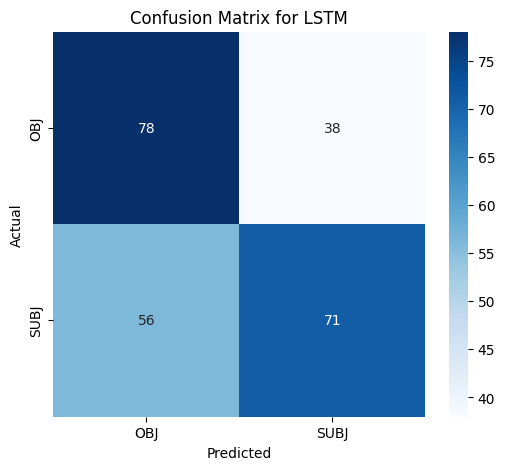


Evaluating BERT Model on Test Set:


Evaluating bert: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]



BERT Test Accuracy: 0.7695
BERT Test Precision: 0.7730
BERT Test Recall: 0.7695
BERT Test F1-Score: 0.7678
BERT Matthews Correlation Coefficient: 0.5402

BERT Classification Report:
              precision    recall  f1-score   support

         OBJ       0.80      0.69      0.74       116
        SUBJ       0.75      0.84      0.79       127

    accuracy                           0.77       243
   macro avg       0.77      0.77      0.77       243
weighted avg       0.77      0.77      0.77       243

Confusion matrix, without normalization


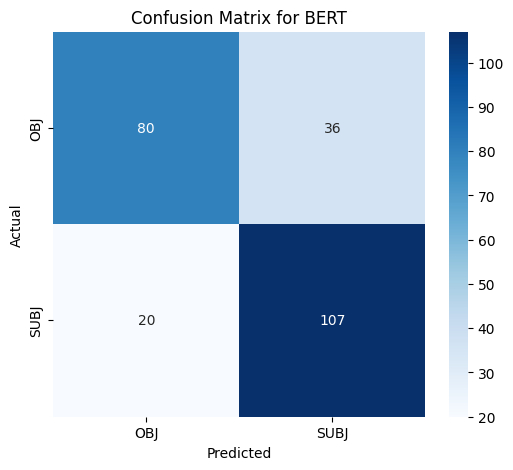

In [13]:
print("\nEvaluating LSTM Model on Test Set:")
test_preds_lstm, test_labels_lstm, test_probs_lstm, acc_lstm, precision_lstm, recall_lstm, f1_lstm, mcc_lstm = evaluateAndPlot(
    model=lstm_model,
    data_loader=test_loader_lstm,
    device=device,
    model_type='lstm',
    threshold=0.5
)

print("\nEvaluating BERT Model on Test Set:")
test_preds_bert, test_labels_bert, test_probs_bert, acc_bert, precision_bert, recall_bert, f1_bert, mcc_bert = evaluateAndPlot(
    model=bert_model,
    data_loader=test_loader_bert,
    device=device,
    model_type='bert',
    threshold=0.5
)

**10 - Hyperparameter Tuning (Grid Search)**

In [14]:
# Define the hyperparameter grid for LSTM
hyperparams_lstm_grid = [
    {
        'learning_rate': 1e-3,
        'hidden_size': 128,
        'n_layers': 1,
        'dropout': 0.3,
        'batch_size': 32
    },
      {
        'learning_rate': 1e-3,
        'hidden_size': 256,
        'n_layers': 2,
        'dropout': 0.5,
        'batch_size': 64
    },
    {
        'learning_rate': 5e-4,
        'hidden_size': 128,
        'n_layers': 1,
        'dropout': 0.5,
        'batch_size': 32
    },
      {
        'learning_rate': 5e-4,
        'hidden_size': 256,
        'n_layers': 2,
        'dropout': 0.3,
        'batch_size': 64
    },
      {
        'learning_rate': 1e-3,
        'hidden_size': 256,
        'n_layers': 1,
        'dropout': 0.5,
        'batch_size': 32
    },
    
]

# function  for grid search 
def gridSearchForLstm(train_df, val_df, tokenizer, hyperparams, max_length=128, epochs=10, patience=2):
    results = []
    best_val_acc = 0
    best_hyperparams = None
    best_historyPerformance = None 

    for idx, params in enumerate(hyperparams, 1):
        print(f"\n--- Grid Search Run {idx}/{len(hyperparams)} ---")
        print(f"Hyperparameters: {params}")
        
        # Create DataLoaders
        train_dataset = DatasetSubjectivity(
            train_df, 
            tokenizer=tokenizer, 
            max_length=max_length, 
            model_type='lstm')
        
        val_dataset = DatasetSubjectivity(
            val_df, 
            tokenizer=tokenizer, 
            max_length=max_length, 
            model_type='lstm')
        
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
        
        # Initialize model
        model = LSTMModelClassifier(
            vocab_size=len(tokenizer),
            embedding_size=128,
            hidden_size=params['hidden_size'],
            output_size=2,
            n_layers=params['n_layers'],
            bidirectional=True,
            dropout=params['dropout'],
            pad_size=tokenizer.pad_token_id
        )
        model = model.to(device)
        
        # Define Early Stopping parameters
        bestValLoss = float('inf')
        epochsNoImprove = 0

        # Define class weights to handle class imbalance
        classCounts = train_df['label_encoded'].value_counts().sort_index()
        classWeights = 1. / torch.tensor(classCounts, dtype=torch.float)
        classWeights = classWeights.to(device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        lossFn = nn.CrossEntropyLoss(weight=classWeights).to(device)
        
        
        # Initialize historyPerformance
        historyPerformance = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
        
        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            print("-" * 10)
            
            train_acc, train_loss = trainingEpoch(
                model=model,
                data_loader=train_loader,
                lossFn=lossFn,
                optimizer=optimizer,
                device=device,
                scheduler=None,
                model_type='lstm'
            )
            
            print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")
            
            val_acc, val_loss, _, _ = evaluationMmodel(
                model=model,
                data_loader=val_loader,
                lossFn=lossFn,
                device=device,
                model_type='lstm'
            )
            
            print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")
            
            historyPerformance['train_acc'].append(train_acc.cpu().numpy())
            historyPerformance['train_loss'].append(train_loss)
            historyPerformance['val_acc'].append(val_acc.cpu().numpy())
            historyPerformance['val_loss'].append(val_loss)
            
            
            if val_loss < bestValLoss:
                bestValLoss = val_loss
                epochsNoImprove = 0
                # Save the best model 
                torch.save(model.state_dict(), 'grid_best_lstm_model.pth')
                print("Validation loss decreased. Saving the best LSTM model for this hyperparameter set.")
            else:
                epochsNoImprove += 1
                print(f"No improvement in validation loss for {epochsNoImprove} epoch(s).")
                if epochsNoImprove >= patience:
                    print("Early stopping triggered.")
                    break
        
        # Load the best model 
        model.load_state_dict(torch.load('grid_best_lstm_model.pth'))
        
        # Evaluate on validation 
        val_acc_final, val_loss_final, val_preds, val_labels = evaluationMmodel(
            model=model,
            data_loader=val_loader,
            lossFn=lossFn,
            device=device,
            model_type='lstm'
        )
        
        acc, precision, recall, f1, report, cm, mcc = getEvaluationMetrics(
            val_preds, val_labels, label_mapping
        )
        
        print("\nLSTM Classification Report on Validation Set:")
        print(report)
        
        # Store results
        results.append({
            'run': idx,
            'learning_rate': params['learning_rate'],
            'hidden_size': params['hidden_size'],
            'n_layers': params['n_layers'],
            'dropout': params['dropout'],
            'batch_size': params['batch_size'],
            'val_accuracy': acc,
            'val_loss': val_loss_final,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'mcc': mcc
        })
        
        # Update best hyperparameters
        if acc > best_val_acc:
            best_val_acc = acc
            best_hyperparams = params.copy()
            best_historyPerformance = historyPerformance.copy()  
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    print("\nGrid Search Results:")
    print(results_df)
    
    print(f"\nBest Hyperparameters based on Validation Accuracy ({best_val_acc:.4f}):")
    print(best_hyperparams)
    
    return results_df, best_hyperparams, best_historyPerformance

# Perform grid search with the defined hyperparameter grid
print("\nStarting Grid Search for LSTM Hyperparameters...")
results_lstm, best_hyperparams_lstm, historyPerformance_best_lstm = gridSearchForLstm(
    train_df=train_data,
    val_df=val_data,
    tokenizer=bert_tokenizer,
    hyperparams=hyperparams_lstm_grid,  
    max_length=MAX_LENGTH,
    epochs=5,  
    patience=2
)


Starting Grid Search for LSTM Hyperparameters...

--- Grid Search Run 1/5 ---
Hyperparameters: {'learning_rate': 0.001, 'hidden_size': 128, 'n_layers': 1, 'dropout': 0.3, 'batch_size': 32}

Epoch 1/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 26.24it/s]


Train loss 0.6929 accuracy 0.5181


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 33.44it/s]


Val   loss 0.6856 accuracy 0.3976
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 2/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 29.28it/s]


Train loss 0.6623 accuracy 0.6064


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.34it/s]


Val   loss 0.6522 accuracy 0.6265
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 3/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 29.31it/s]


Train loss 0.5885 accuracy 0.6948


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.27it/s]


Val   loss 0.6107 accuracy 0.6265
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 4/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 30.10it/s]


Train loss 0.4375 accuracy 0.7992


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.28it/s]


Val   loss 0.5854 accuracy 0.7831
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 5/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 29.02it/s]


Train loss 0.3079 accuracy 0.8768


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.36it/s]


Val   loss 0.6470 accuracy 0.6867
No improvement in validation loss for 1 epoch(s).


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 37.16it/s]



LSTM Classification Report on Validation Set:
              precision    recall  f1-score   support

         OBJ       0.87      0.77      0.82        53
        SUBJ       0.67      0.80      0.73        30

    accuracy                           0.78        83
   macro avg       0.77      0.79      0.77        83
weighted avg       0.80      0.78      0.79        83


--- Grid Search Run 2/5 ---
Hyperparameters: {'learning_rate': 0.001, 'hidden_size': 256, 'n_layers': 2, 'dropout': 0.5, 'batch_size': 64}

Epoch 1/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.21it/s]


Train loss 0.6961 accuracy 0.5408


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 20.64it/s]


Val   loss 0.6964 accuracy 0.3614
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 2/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.10it/s]


Train loss 0.6716 accuracy 0.5810


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.22it/s]


Val   loss 0.6684 accuracy 0.4819
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 3/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.73it/s]


Train loss 0.5737 accuracy 0.6948


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


Val   loss 0.6995 accuracy 0.6024
No improvement in validation loss for 1 epoch(s).

Epoch 4/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


Train loss 0.4499 accuracy 0.7858


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.34it/s]


Val   loss 0.7297 accuracy 0.5663
No improvement in validation loss for 2 epoch(s).
Early stopping triggered.


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 20.20it/s]



LSTM Classification Report on Validation Set:
              precision    recall  f1-score   support

         OBJ       0.73      0.30      0.43        53
        SUBJ       0.39      0.80      0.53        30

    accuracy                           0.48        83
   macro avg       0.56      0.55      0.48        83
weighted avg       0.61      0.48      0.46        83


--- Grid Search Run 3/5 ---
Hyperparameters: {'learning_rate': 0.0005, 'hidden_size': 128, 'n_layers': 1, 'dropout': 0.5, 'batch_size': 32}

Epoch 1/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 31.58it/s]


Train loss 0.6905 accuracy 0.5622


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.34it/s]


Val   loss 0.6939 accuracy 0.4819
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 2/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 30.34it/s]


Train loss 0.6773 accuracy 0.5703


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.53it/s]


Val   loss 0.6925 accuracy 0.5542
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 3/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 30.07it/s]


Train loss 0.6597 accuracy 0.6479


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.74it/s]


Val   loss 0.6930 accuracy 0.4940
No improvement in validation loss for 1 epoch(s).

Epoch 4/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 30.29it/s]


Train loss 0.6152 accuracy 0.6854


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.40it/s]


Val   loss 0.6787 accuracy 0.5542
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 5/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 30.37it/s]


Train loss 0.5405 accuracy 0.7216


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.77it/s]


Val   loss 0.6564 accuracy 0.6024
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.38it/s]



LSTM Classification Report on Validation Set:
              precision    recall  f1-score   support

         OBJ       0.70      0.66      0.68        53
        SUBJ       0.45      0.50      0.48        30

    accuracy                           0.60        83
   macro avg       0.58      0.58      0.58        83
weighted avg       0.61      0.60      0.61        83


--- Grid Search Run 4/5 ---
Hyperparameters: {'learning_rate': 0.0005, 'hidden_size': 256, 'n_layers': 2, 'dropout': 0.3, 'batch_size': 64}

Epoch 1/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.12it/s]


Train loss 0.6946 accuracy 0.4819


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.32it/s]


Val   loss 0.6894 accuracy 0.6506
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 2/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.55it/s]


Train loss 0.6853 accuracy 0.5301


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.47it/s]


Val   loss 0.6760 accuracy 0.4699
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 3/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.10it/s]


Train loss 0.6463 accuracy 0.6653


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.43it/s]


Val   loss 0.6441 accuracy 0.5422
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 4/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.63it/s]


Train loss 0.5639 accuracy 0.6961


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.58it/s]


Val   loss 0.6264 accuracy 0.5663
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 5/5
----------


Training: 100%|██████████| 12/12 [00:00<00:00, 12.61it/s]


Train loss 0.4735 accuracy 0.7858


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.30it/s]


Val   loss 0.6713 accuracy 0.5663
No improvement in validation loss for 1 epoch(s).


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.19it/s]



LSTM Classification Report on Validation Set:
              precision    recall  f1-score   support

         OBJ       0.74      0.49      0.59        53
        SUBJ       0.44      0.70      0.54        30

    accuracy                           0.57        83
   macro avg       0.59      0.60      0.56        83
weighted avg       0.63      0.57      0.57        83


--- Grid Search Run 5/5 ---
Hyperparameters: {'learning_rate': 0.001, 'hidden_size': 256, 'n_layers': 1, 'dropout': 0.5, 'batch_size': 32}

Epoch 1/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 27.92it/s]


Train loss 0.6983 accuracy 0.5087


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 36.64it/s]


Val   loss 0.6983 accuracy 0.6386
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 2/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 27.24it/s]


Train loss 0.6543 accuracy 0.6493


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 35.04it/s]


Val   loss 0.6611 accuracy 0.6386
Validation loss decreased. Saving the best LSTM model for this hyperparameter set.

Epoch 3/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 26.65it/s]


Train loss 0.5441 accuracy 0.7349


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 33.53it/s]


Val   loss 0.6699 accuracy 0.5542
No improvement in validation loss for 1 epoch(s).

Epoch 4/5
----------


Training: 100%|██████████| 24/24 [00:00<00:00, 26.12it/s]


Train loss 0.4513 accuracy 0.7805


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 30.86it/s]


Val   loss 0.6799 accuracy 0.6747
No improvement in validation loss for 2 epoch(s).
Early stopping triggered.


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 30.59it/s]


LSTM Classification Report on Validation Set:
              precision    recall  f1-score   support

         OBJ       0.71      0.74      0.72        53
        SUBJ       0.50      0.47      0.48        30

    accuracy                           0.64        83
   macro avg       0.60      0.60      0.60        83
weighted avg       0.63      0.64      0.64        83


Grid Search Results:
   run  learning_rate  hidden_size  n_layers  dropout  batch_size  \
0    1         0.0010          128         1      0.3          32   
1    2         0.0010          256         2      0.5          64   
2    3         0.0005          128         1      0.5          32   
3    4         0.0005          256         2      0.3          64   
4    5         0.0010          256         1      0.5          32   

   val_accuracy  val_loss  precision    recall  f1_score       mcc  
0      0.783133  0.585401   0.798001  0.783133  0.786484  0.556027  
1      0.481928  0.668401   0.606611  0.481928  0.4

**11 - Results and Analysis**

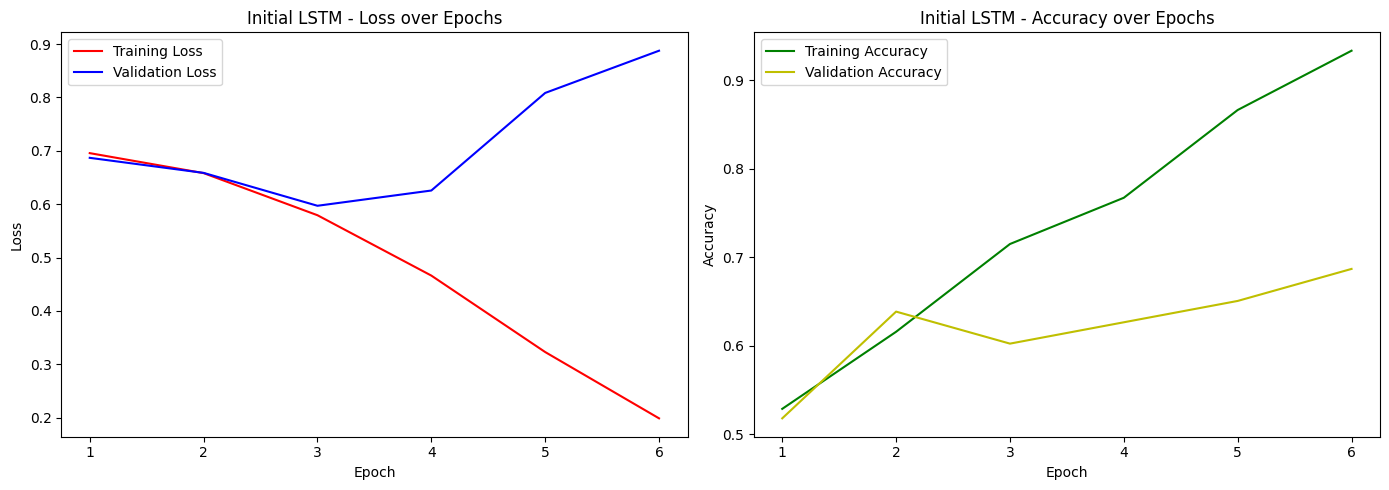

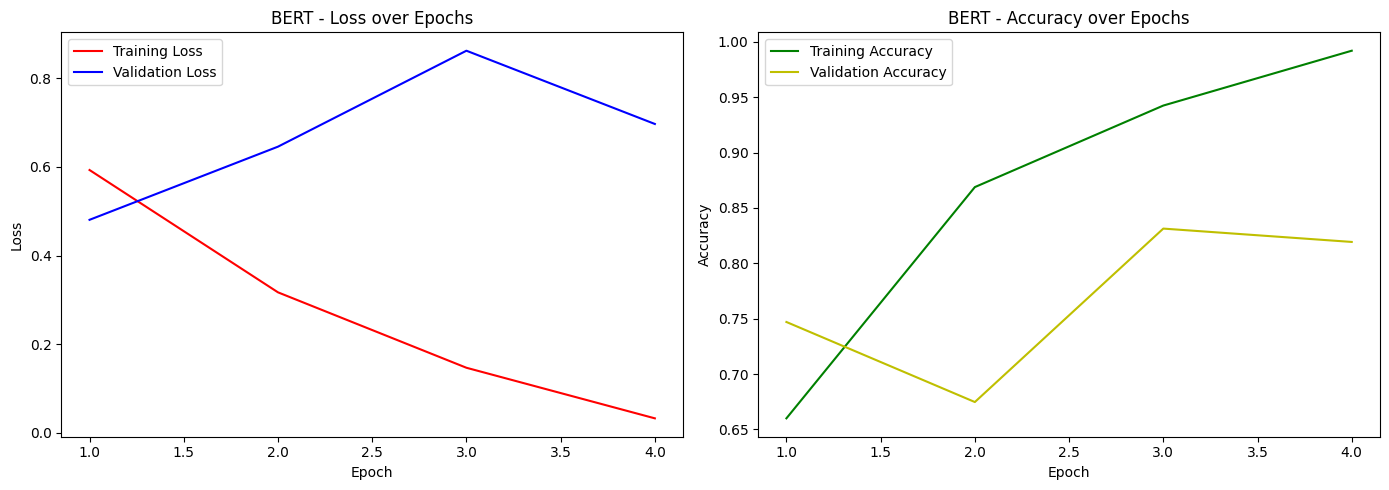

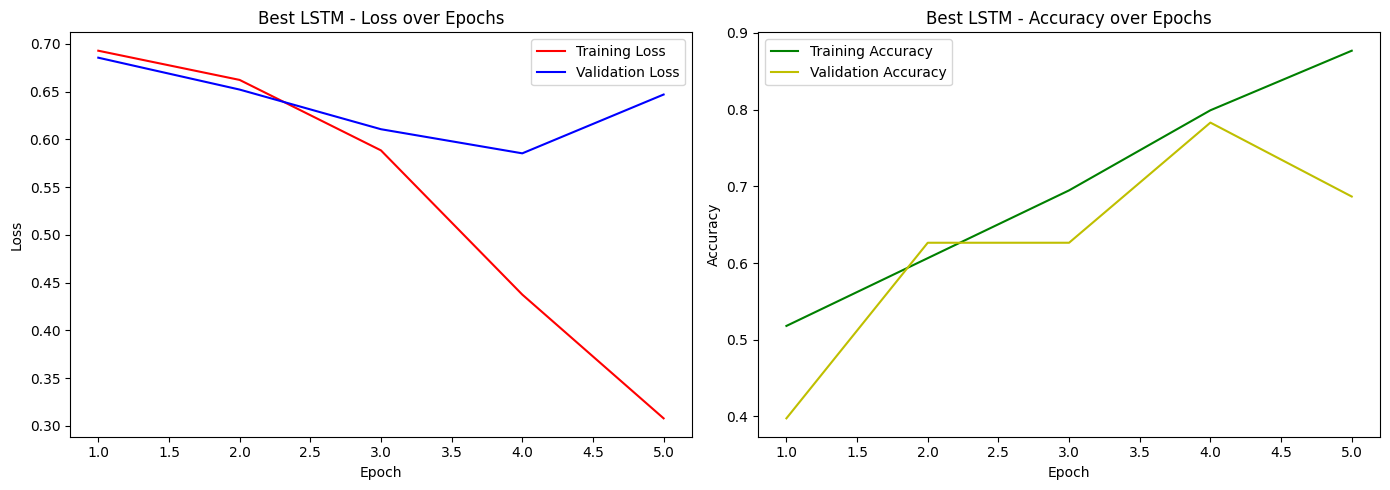

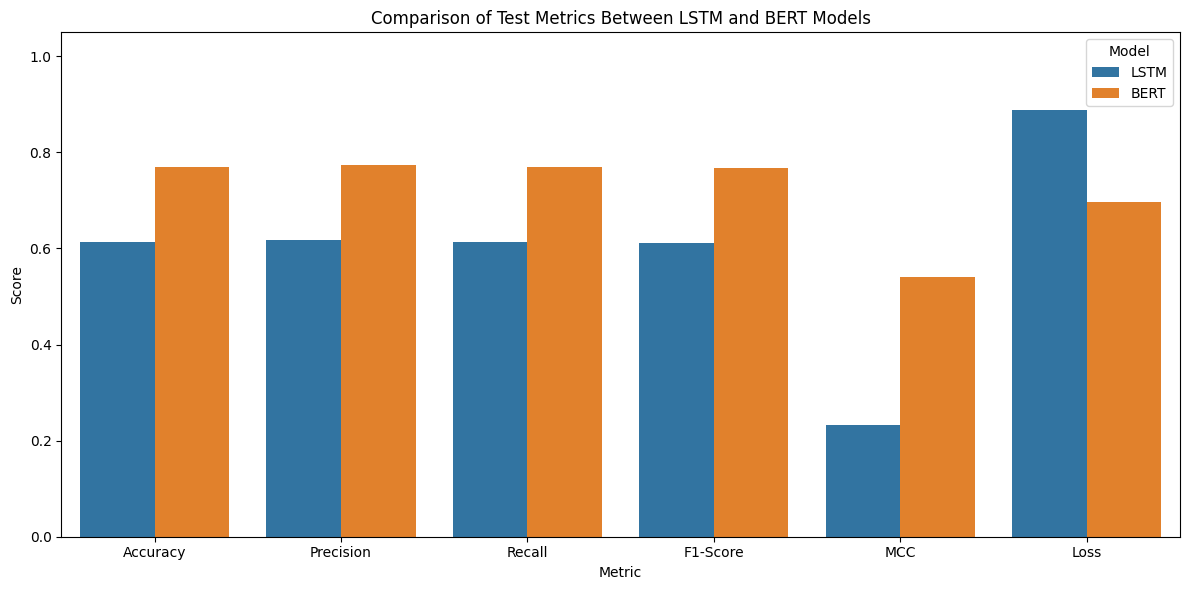

In [15]:
def plot_training_historyPerformancePerformance(historyPerformance, model_name='Model'):
 
    epochs_range = range(1, len(historyPerformance['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, historyPerformance['train_loss'], 'r-', label='Training Loss')
    plt.plot(epochs_range, historyPerformance['val_loss'], 'b-', label='Validation Loss')
    plt.title(f'{model_name} - Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, historyPerformance['train_acc'], 'g-', label='Training Accuracy')
    plt.plot(epochs_range, historyPerformance['val_acc'], 'y-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_historyPerformancePerformance(perfLstm, model_name='Initial LSTM')
plot_training_historyPerformancePerformance(historyPerformance_bert, model_name='BERT')
plot_training_historyPerformancePerformance(historyPerformance_best_lstm, model_name='Best LSTM')

# Create a comprehensive comparison bar chart for Test Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Loss']
bert_metrics = [acc_bert.item(), precision_bert, recall_bert, f1_bert, mcc_bert, historyPerformance_bert['val_loss'][-1]]
lstm_metrics = [acc_lstm.item(), precision_lstm, recall_lstm, f1_lstm, mcc_lstm, perfLstm['val_loss'][-1]]

# Organize data for plotting
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'LSTM': lstm_metrics,
    'BERT': bert_metrics
})

comparison_melted = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score')
metric_order = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Loss']

# Plot the comparison bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted, order=metric_order)
plt.title('Comparison of Test Metrics Between LSTM and BERT Models')
plt.ylim(0,1.05)  # Adjusted to accommodate all metrics, especially Loss which might be less than 1
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

**12 - Saving Models**

In [16]:
def save_training_results(lstm_model, bert_model, 
                          test_labels_lstm, test_preds_lstm, 
                          test_labels_bert, test_preds_bert, 
                          results_lstm):
    
    # Save the trained models
    torch.save(lstm_model.state_dict(), 'best_lstm_model_final.pth')
    torch.save(bert_model.state_dict(), 'best_bert_model_final.pth')
    print("Final trained models saved as 'best_lstm_model_final.pth' and 'best_bert_model_final.pth'.")

    # Save classification reports
    report_lstm = classification_report(
        test_labels_lstm, test_preds_lstm, 
        target_names=['OBJ', 'SUBJ'], 
        output_dict=True
    )
    report_lstm_df = pd.DataFrame(report_lstm).transpose()
    report_lstm_df.to_csv('lstm_classification_report.csv', index=True)

    report_bert = classification_report(
        test_labels_bert, test_preds_bert, 
        target_names=['OBJ', 'SUBJ'], 
        output_dict=True
    )
    report_bert_df = pd.DataFrame(report_bert).transpose()
    report_bert_df.to_csv('bert_classification_report.csv', index=True)

    print("Classification reports saved as 'lstm_classification_report.csv' and 'bert_classification_report.csv'.")

    # Save hyperparameter tuning results
    if not results_lstm.empty:
        results_lstm.to_csv('lstm_hyperparameter_tuning_results.csv', index=False)
        print("Hyperparameter tuning results saved as 'lstm_hyperparameter_tuning_results.csv'.")


save_training_results(
    lstm_model=lstm_model,
    bert_model=bert_model,
    test_labels_lstm=test_labels_lstm,
    test_preds_lstm=test_preds_lstm,
    test_labels_bert=test_labels_bert,
    test_preds_bert=test_preds_bert,
    results_lstm=results_lstm
)

Final trained models saved as 'best_lstm_model_final.pth' and 'best_bert_model_final.pth'.
Classification reports saved as 'lstm_classification_report.csv' and 'bert_classification_report.csv'.
Hyperparameter tuning results saved as 'lstm_hyperparameter_tuning_results.csv'.
